In [143]:
from get_embedding import get_embedding
from diffusion import *
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap

import os
import glob
import random

In [151]:
# Todo
# Set Parameters:

n_neighbors=100
step=(60,60)

grid=(30,30)
dt = 0.001
t_total = 10000
n_repeats = 10

detail_result_path = '/Users/pengzhizhang/Documents/test_data/neuro/velocity_result'
output_path = detail_result_path
raw_data_path = '/Users/pengzhizhang/Documents/test_data/neuro/raw_data'



In [145]:
load_raw_data = pd.read_csv(os.path.join(raw_data_path, 'denGyr_full.csv'))

In [146]:
detail_files = glob.iglob(os.path.join(detail_result_path, 'detail*.csv'))
lcd = list()
for f in detail_files:
    load_cellDancer_temp = pd.read_csv(f)
    load_cellDancer_temp.rename(columns = {'Unnamed: 0':'cellIndex'}, inplace = True)
    load_cellDancer_temp = load_cellDancer_temp.sort_values(by = ['gene_name', 'cellIndex'], ascending = [True, True])
    lcd.append(load_cellDancer_temp)
load_cellDancer = pd.concat(lcd)

neighbors
tranfer mode: None
None
using gene mode
(2148, 18140)
(2148, 18140)


/Users/pengzhizhang/cellDancer-activate/src/get_embedding.py:50: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt(np.dot(ematrix_ss[:, None], vmatrix_ss[None]))


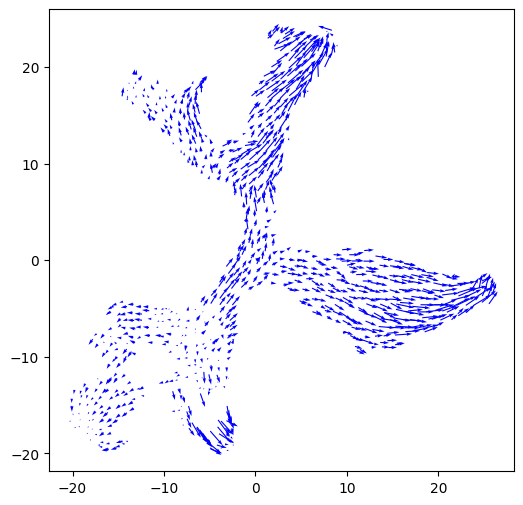

In [147]:
gene_choice=list(set(load_cellDancer.gene_name))


embedding, sampling_ixs, velocity_embedding = get_embedding(
    load_raw_data=load_raw_data, 
    load_cellDancer=load_cellDancer, 
    gene_list=gene_choice,
    mode="gene",
    n_neighbors=n_neighbors,
    step=step)

fig, ax = plt.subplots(figsize=(6,6))
#plt.scatter(embedding[:, 0],embedding[:, 1], c="Silver", s=5, alpha=1)
plt.quiver(embedding[sampling_ixs, 0],embedding[sampling_ixs, 1],
          velocity_embedding[:,0], velocity_embedding[:,1], color='Blue')
plt.show()

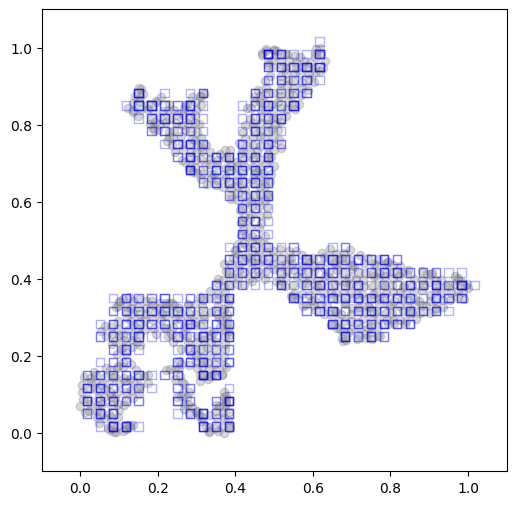

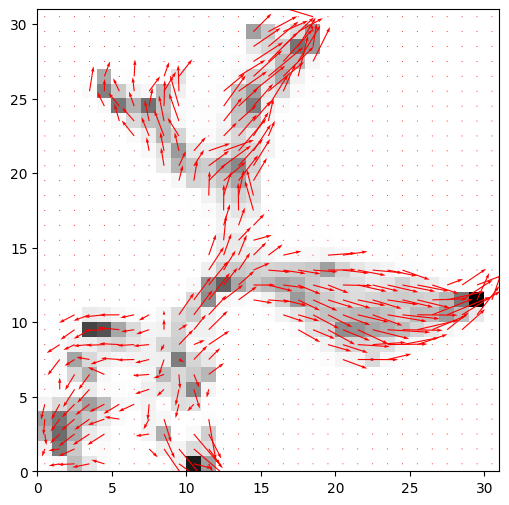

In [148]:
import importlib,sys
importlib.reload(sys.modules['diffusion'])
from diffusion import *
cell_embedding, normalized_embedding = embedding_normalization(
    embedding[sampling_ixs], embedding, mode='minmax', NORM_ALL_CELLS=True)

velocity = velocity_normalization(velocity_embedding, mode='max')

vel_mesh, grid_density, cell_grid_idx, cell_grid_coor, all_grid_idx, all_grid_coor = \
generate_grid(cell_embedding, normalized_embedding, velocity, steps=grid)
plot_mesh_velocity(vel_mesh, grid_density)

In [152]:
import time

start_time = time.time()
paths = run_diffusion(cell_embedding, vel_mesh, grid_density, dt=dt, t_total=t_total, 
                      eps=1e-5, off_cell_init=False, n_repeats = n_repeats, n_jobs = mp.cpu_count()-1) 
print("--- %s seconds ---" % (time.time() - start_time))

--- 214.8062562942505 seconds ---


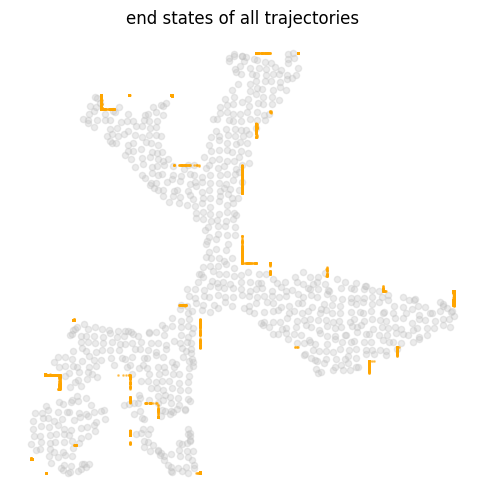

Currently  0 clusters:	 8702 paths to be categorized
Currently  1 clusters:	 4488 paths to be categorized
Currently  2 clusters:	 2706 paths to be categorized
Currently  3 clusters:	 1297 paths to be categorized
Currently  4 clusters:	 828 paths to be categorized
Currently  5 clusters:	 0 paths to be categorized


In [153]:
newPaths = purge_end_state_stuttering(paths, cell_embedding)
traj_displacement = np.array([compute_trajectory_displacement(ipath) for ipath in newPaths])
# sorted from long to short
order = np.argsort(traj_displacement)[::-1]
sorted_traj = newPaths[order]
traj_displacement=traj_displacement[order]


path_clusters = list()
cell_clusters = list()
path_clusters, cell_clusters = clustering(path_clusters, cell_clusters, 
    sorted_traj, traj_displacement, 0.2, 0, nkeep=-1)

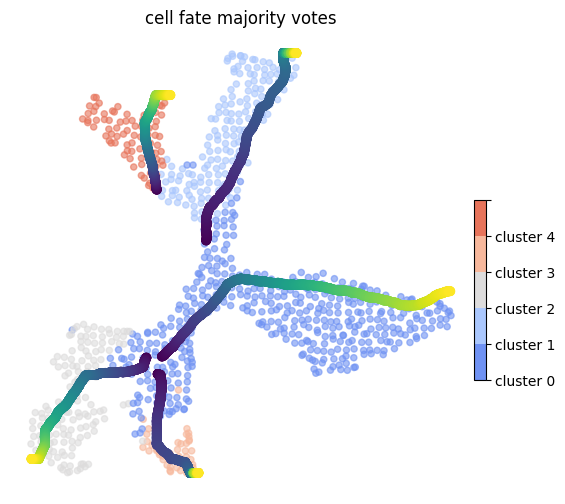

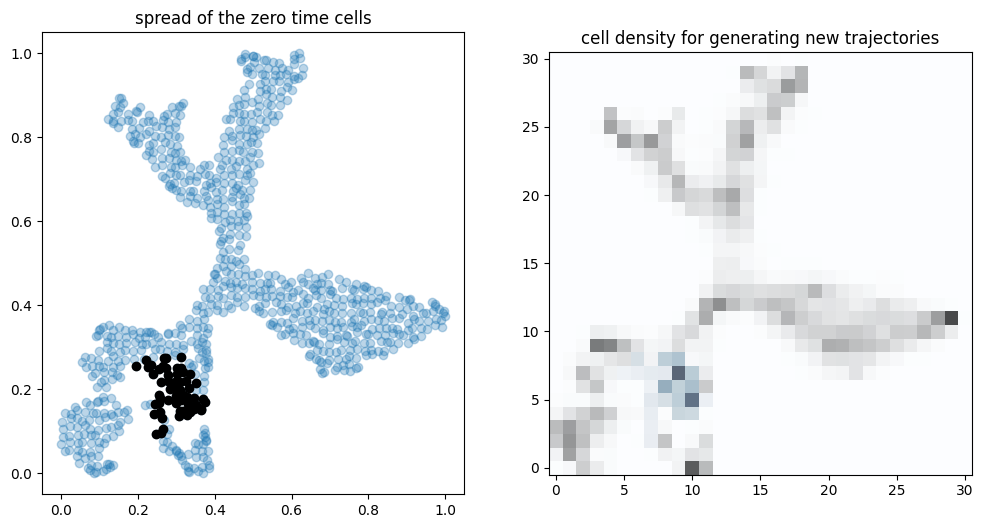

Sampling new trajectories for zero-time cells in cluster  0   ...
The closest distance is  0.04250589084331385
Between dot 0  from refPath1 and dot 0 from refPath2.


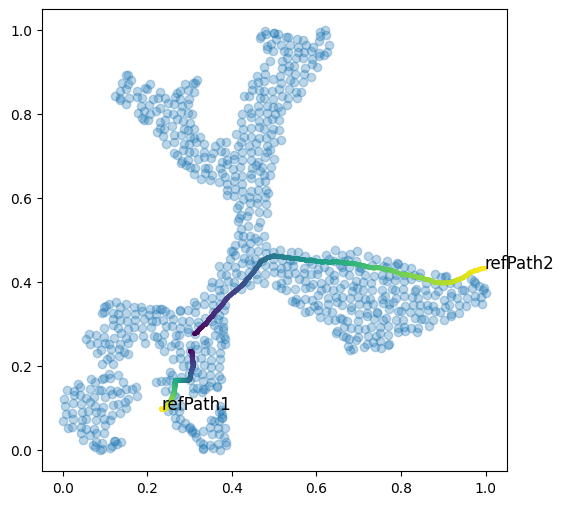

now the cell time is updated for cluster:  0
shifting ref_path2 by time  0


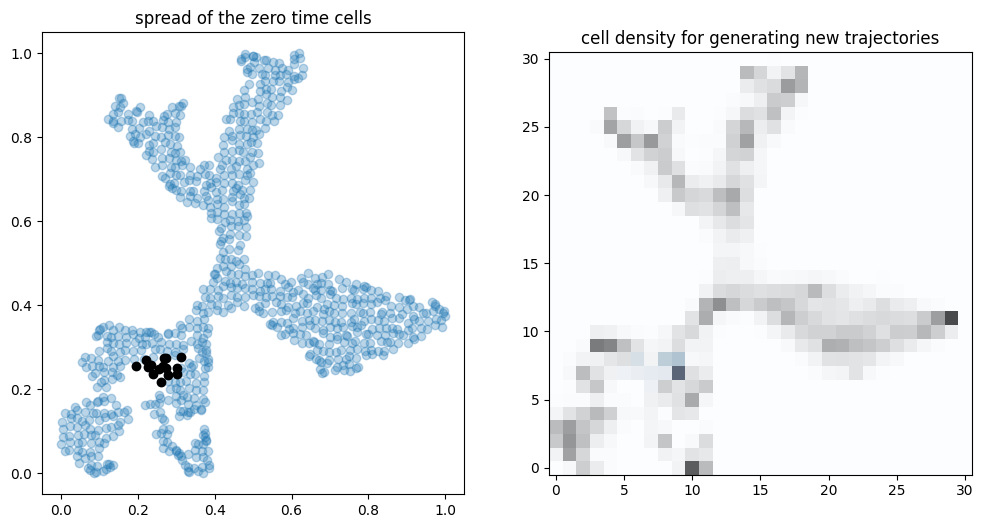

Sampling new trajectories for zero-time cells in cluster  0   ...
The closest distance is  0.023564620398479823
Between dot 0  from refPath1 and dot 0 from refPath2.


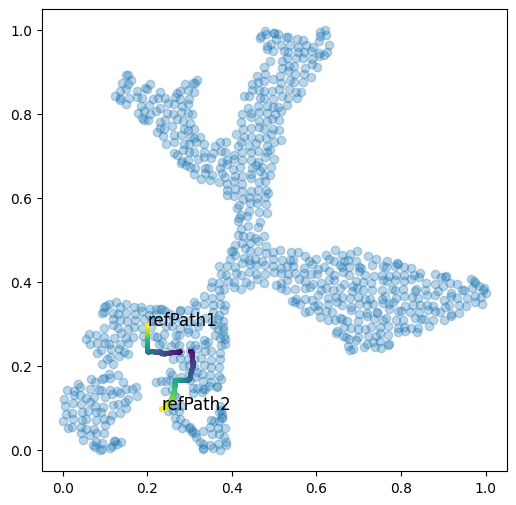

now the cell time is updated for cluster:  0
shifting ref_path2 by time  0

All intra cluster cell time has been resolved.




Plotting cluster internal time



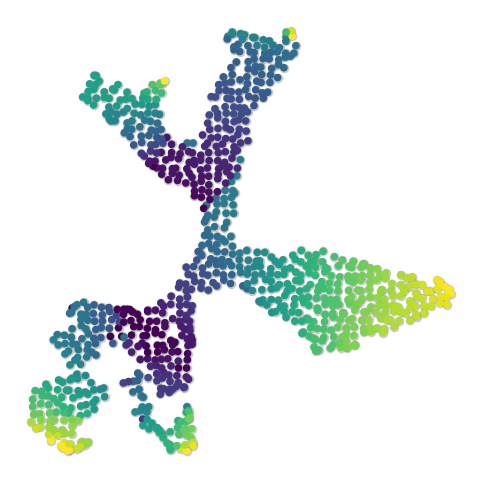

{1: 381, 7: 378, 18: 272, 20: 378, 23: 166, 29: 381, 36: 123, 39: 322, 62: 161, 63: 260, 65: 102, 68: 322, 72: 294, 79: 421, 83: 294, 85: 319, 91: 341, 93: 381, 103: 194, 104: 228, 106: 428, 114: 212, 127: 381, 128: 381, 136: 363, 142: 180, 155: 363, 164: 310, 172: 388, 179: 381, 181: 385, 185: 263, 192: 17, 193: 378, 195: 381, 203: 310, 212: 378, 213: 396, 214: 378, 218: 484, 220: 382, 223: 378, 229: 310, 241: 363, 245: 310, 249: 378, 253: 287, 254: 260, 262: 378, 272: 161, 274: 224, 276: 378, 283: 341, 289: 51, 291: 96, 298: 378, 311: 123, 321: 349, 345: 189, 346: 381, 348: 224, 353: 357, 357: 194, 362: 310, 363: 228, 371: 322, 382: 322, 393: 51, 396: 230, 402: 55, 413: 243, 466: 303, 543: 457, 551: 378, 580: 509, 607: 509, 625: 457, 629: 381, 639: 662, 649: 303, 752: 251, 763: 417}
[0, 1, 2, 3, 4]


Consoliding time between clusters  0  and  1 




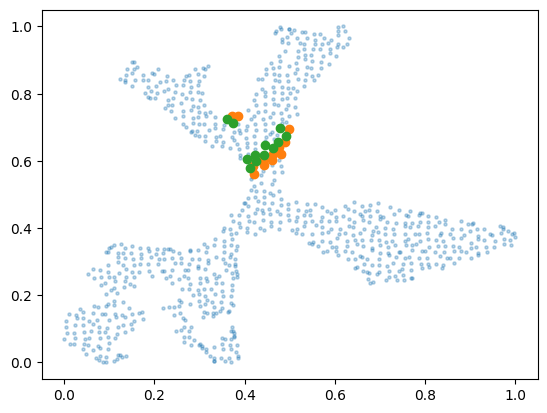

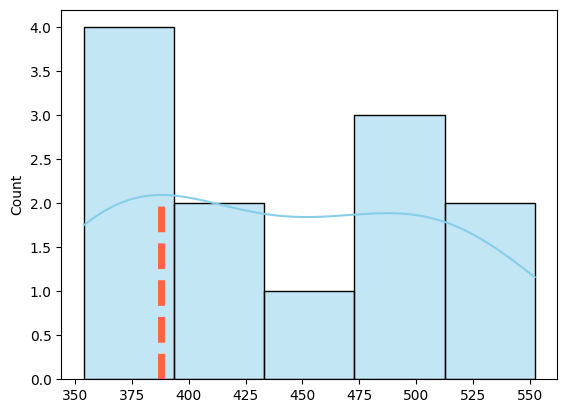

shift time is:  397 .
 The overlapping cells are:
 cell  397  from cluster  0  and  225  from cluster  1


Consoliding time between clusters  0  and  2 




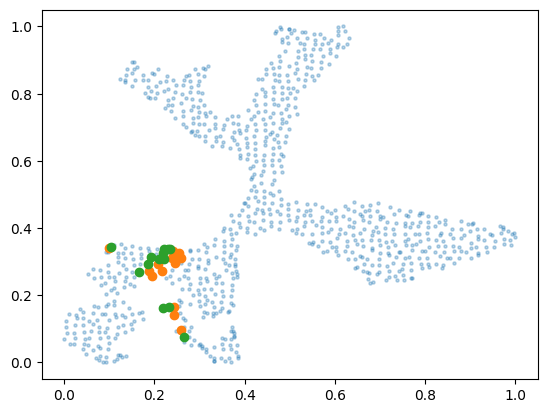

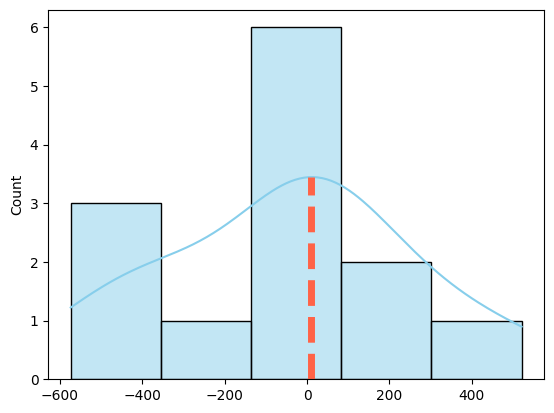

shift time is:  0 .
 The overlapping cells are:
 cell  404  from cluster  0  and  331  from cluster  2


Consoliding time between clusters  0  and  3 




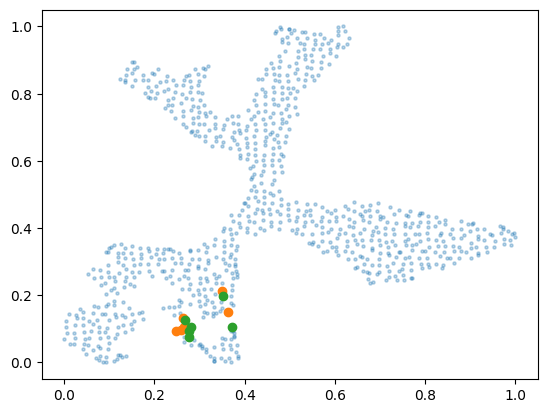

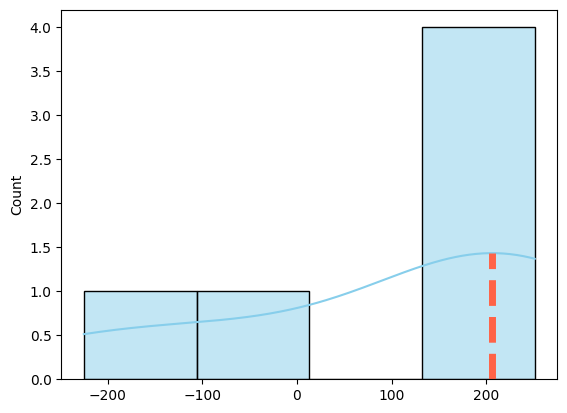

shift time is:  216 .
 The overlapping cells are:
 cell  557  from cluster  0  and  782  from cluster  3


Consoliding time between clusters  0  and  4 


No close cells between clusters	 (0, 4)


Consoliding time between clusters  1  and  2 


No close cells between clusters	 (1, 2)


Consoliding time between clusters  1  and  3 


No close cells between clusters	 (1, 3)


Consoliding time between clusters  1  and  4 




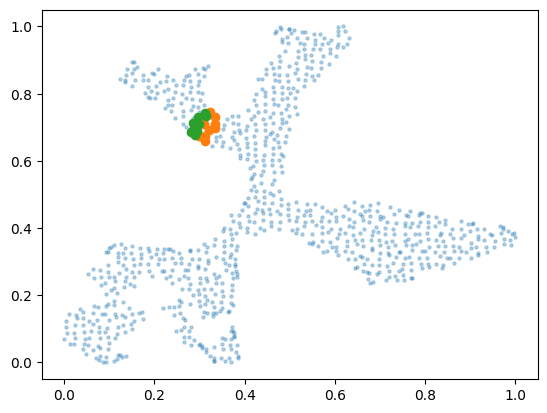

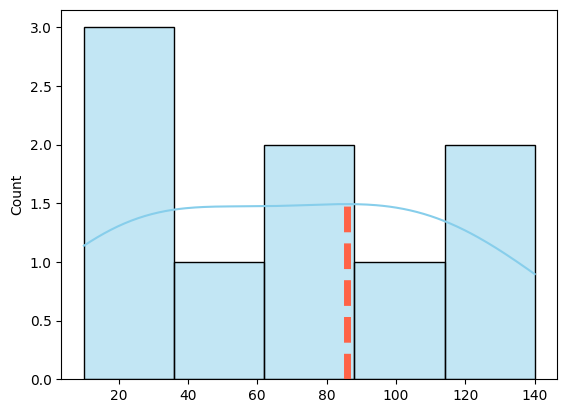

shift time is:  87 .
 The overlapping cells are:
 cell  27  from cluster  1  and  393  from cluster  4


Consoliding time between clusters  2  and  3 




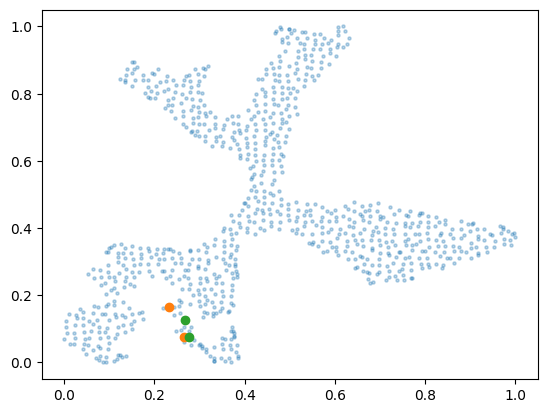

shift time is:  0 .
 The overlapping cells are:
 cell  493  from cluster  2  and  384  from cluster  3


Consoliding time between clusters  2  and  4 


No close cells between clusters	 (2, 4)


Consoliding time between clusters  3  and  4 


No close cells between clusters	 (3, 4)


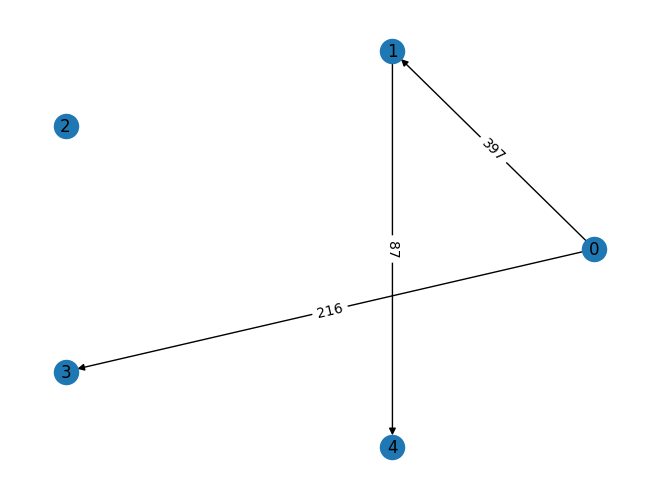

[397 216  87]
[[0 1]
 [0 3]
 [1 4]]
Forward: 0
Pass: 1
Forward: 1
Pass: 4
Pass: 4
Backward: 4
Backward: 1
Forward: 0
Pass: 3
[  0 397   0 216 484]
{1: 865, 7: 862, 18: 756, 20: 862, 23: 650, 29: 865, 36: 607, 39: 806, 62: 645, 63: 744, 65: 586, 68: 806, 72: 778, 79: 905, 83: 778, 85: 803, 91: 825, 93: 865, 103: 678, 104: 712, 106: 912, 114: 696, 127: 865, 128: 865, 136: 847, 142: 664, 155: 847, 164: 794, 172: 872, 179: 865, 181: 869, 185: 747, 192: 501, 193: 862, 195: 865, 203: 794, 212: 862, 213: 880, 214: 862, 218: 968, 220: 866, 223: 862, 229: 794, 241: 847, 245: 794, 249: 862, 253: 771, 254: 744, 262: 862, 272: 645, 274: 708, 276: 862, 283: 825, 289: 535, 291: 580, 298: 862, 311: 607, 321: 833, 345: 673, 346: 865, 348: 708, 353: 841, 357: 678, 362: 794, 363: 712, 371: 806, 382: 806, 393: 535, 396: 714, 402: 539, 413: 727, 466: 787, 543: 941, 551: 862, 580: 993, 607: 993, 625: 941, 629: 865, 639: 1146, 649: 787, 752: 735, 763: 901}



Plotting estimated pseudotime for all cells ...


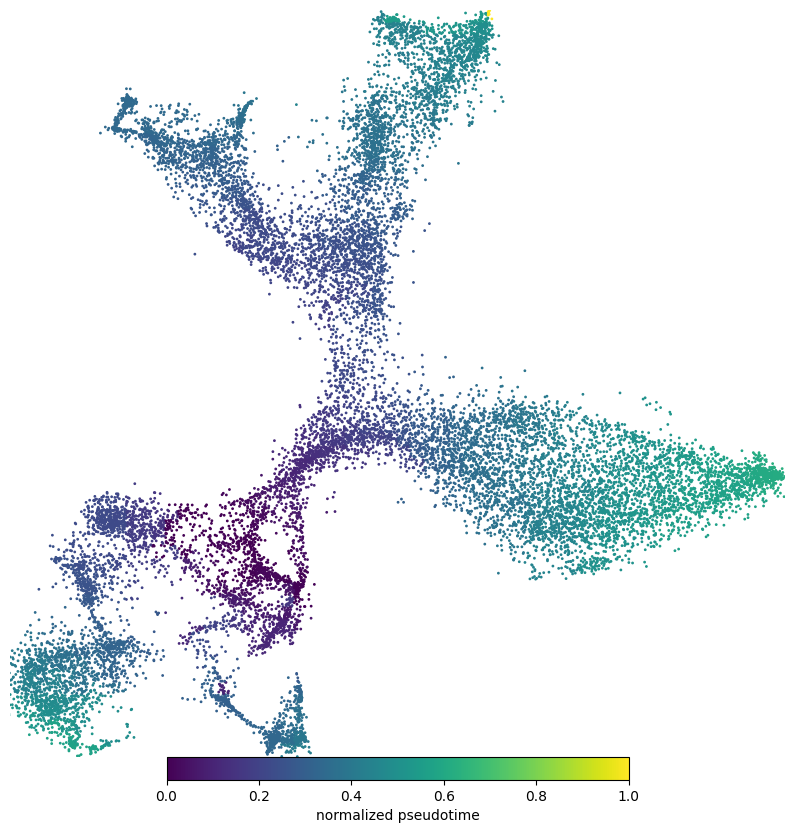

In [258]:
import importlib,sys
importlib.reload(sys.modules['diffusion'])
from diffusion import *
all_cell_time = compute_all_cell_time(embedding, cell_embedding, path_clusters, cell_clusters, 
                                         vel_mesh, cell_grid_idx, grid_density, sampling_ixs=sampling_ixs, step=step,
                                         dt=dt, t_total=t_total, n_repeats = n_repeats, 
                                         n_jobs=mp.cpu_count()-1)



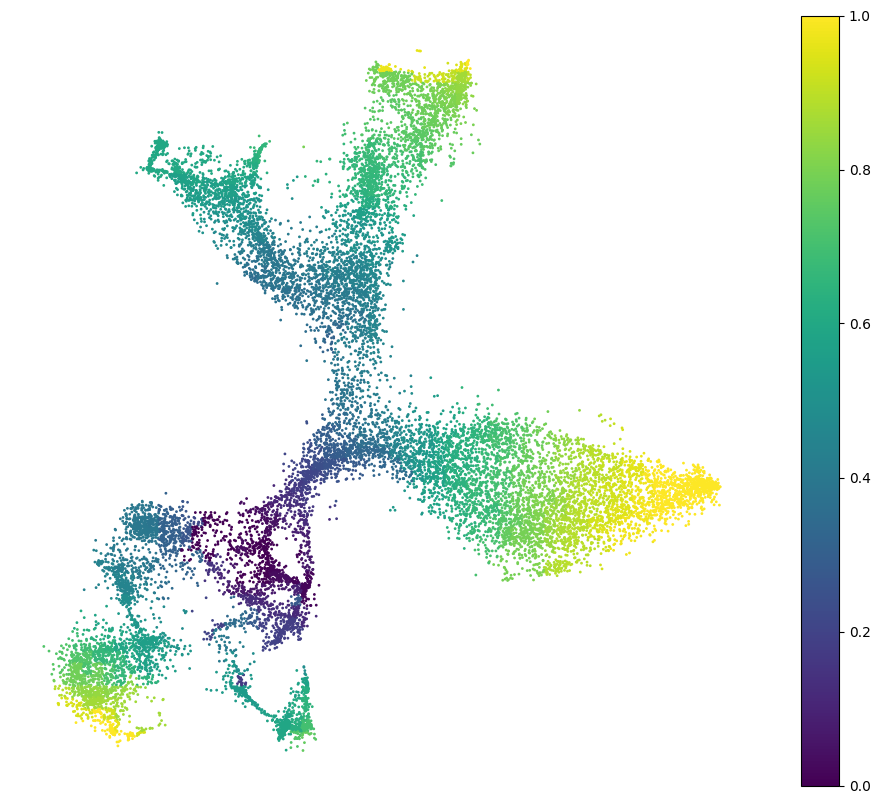

In [304]:
fig,ax = plt.subplots(figsize=(12,10))
plt.scatter(embedding[:,0],embedding[:,1], c=all_cell_time, s = 1, alpha =1)
plt.axis('off')
plt.clim(0, 1)
plt.colorbar()
plt.show()

In [262]:
all_cell_time[all_cell_time>np.quantile(all_cell_time, 0.95)]=np.quantile(all_cell_time, 0.95)

In [268]:
temp = embedding - embedding[:,None]
dist = np.linalg.norm(temp, axis=2)

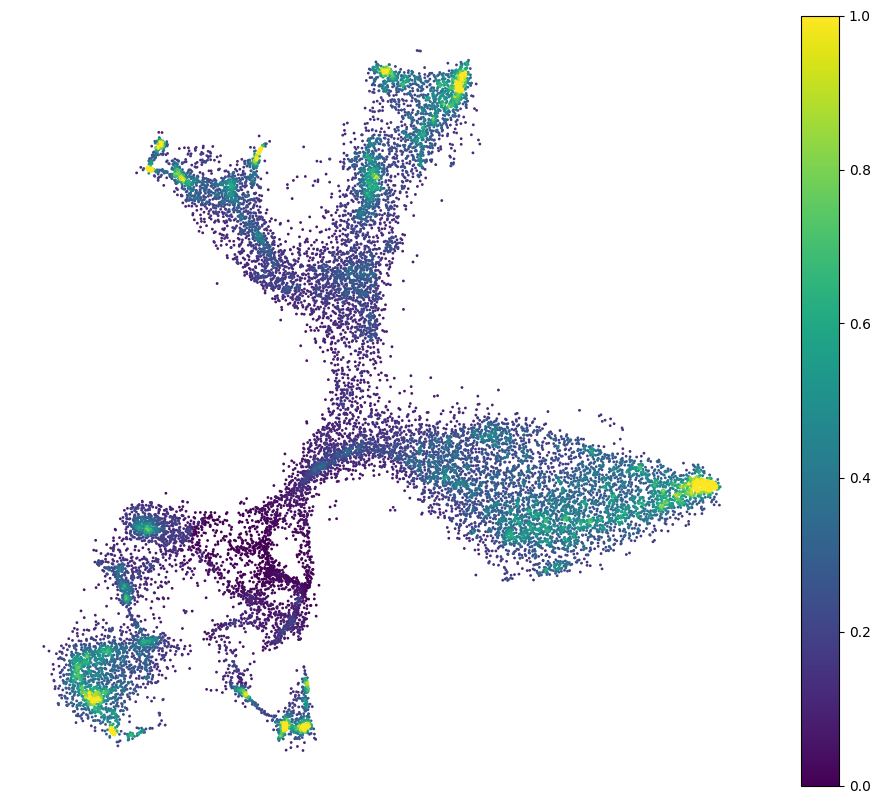

In [301]:
new_time = np.sum(np.exp(-dist/0.1)*all_cell_time, axis=1)
new_time[new_time>np.quantile(new_time, 0.95)]=np.quantile(new_time, 0.95)
new_time /= np.max(new_time)

fig,ax = plt.subplots(figsize=(12,10))
plt.scatter(embedding[:,0], embedding[:,1], c = new_time, s = 1, alpha =1)
plt.axis('off')
plt.minorticks_on()
plt.grid(visible=True, which='major', linestyle='-')
plt.grid(visible=True, which='minor', linestyle='--')
    
plt.clim(0, 1)
plt.colorbar()
plt.show()

In [1]:
from datashader.layout import forceatlas2_layout

In [2]:
help(forceatlas2_layout)

Help on class forceatlas2_layout in module datashader.layout:

class forceatlas2_layout(LayoutAlgorithm)
 |  forceatlas2_layout(*args, **params)
 |  
 |  params(dim=Integer, iterations=Integer, k=Number, linlog=Boolean, nohubs=Boolean, id=String, seed=Integer, source=String, target=String, weight=String, x=String, y=String, name=String)
 |  
 |      Assign coordinates to the nodes using force-directed algorithm.
 |  
 |      This is a force-directed graph layout algorithm called
 |      `ForceAtlas2`.
 |  
 |      Timothee Poisot's `nxfa2` is the original implementation of this
 |      algorithm.
 |  
 |      .. _ForceAtlas2:
 |         http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0098679&type=printable
 |      .. _nxfa2:
 |         https://github.com/tpoisot/nxfa2
 |      
 |  Parameters of 'forceatlas2_layout'
 |  ==================================
 |  
 |  Parameters changed from their default values are marked in red.
 |  Soft bound values are marked in cya